<a href="https://colab.research.google.com/github/Sarztak/CelebA-GAlium-Nitride/blob/main/celeb_A_Conv_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install rich
! rm -rf celeba_np

In [2]:
import torchvision.datasets
import zipfile
from pathlib import Path
from PIL import Image
import os
import shutil
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from rich.traceback import install
import torch.nn as nn
import pandas as pd
import re

install()


drive_path = Path('./drive/MyDrive/img_align_celeba.zip')
local_dir = Path("./celeba_np")
local_dir.mkdir(exist_ok=True)

In [3]:
total_img = 20_000
count = 0
pbar = tqdm(total=total_img, unit=" arr")
with pbar:
    with zipfile.ZipFile(drive_path, 'r') as zf:
        for filename in zf.namelist():
            if filename[-4:] == '.jpg':
                ofile = zf.extract(filename)
                img = Image.open(ofile)
                img_arr = np.array(img)
                img_name = '0'*(6 - len(str(count))) + str(count)
                np.save(local_dir / f"{img_name}.npy", img_arr)
                os.remove(ofile)
                count += 1
                pbar.update(1)
                if count == total_img:
                    break


  0%|          | 0/20000 [00:00<?, ? arr/s]

In [4]:
def center_crop(img, new_height, new_width):
    height, width, _ = img.shape
    start_x = width // 2 - new_height // 2
    start_y = height // 2 - new_width // 2
    return img[start_y: start_y + new_height, start_x: start_x + new_width, :]


# dataset
class CelebADataset(Dataset):
    def __init__(self, path="celeba_np", crop_height=128, crop_width=128):
        self.folder_path = Path(path) # path relative to current directory
        self.file_path_list = sorted([self.folder_path / f for f in os.listdir(self.folder_path)])
        self.text_idx = {}
        self.crop_height, self.crop_width = crop_height, crop_width

    def __len__(self):
        return len(self.file_path_list)

    def __getitem__(self, idx):
        self.text_idx[idx] = self.file_path_list[idx]
        img_arr = np.load(self.file_path_list[idx])
        img_arr_cropped = center_crop(img_arr, self.crop_height, self.crop_width)
        img_tensor = torch.from_numpy(img_arr_cropped).permute(2, 0, 1).unsqueeze(0) / 255.0
        return img_tensor # no label here

    def plot_image(self, idx):
        img_arr = np.load(self.file_list[idx])
        img_arr_cropped = center_crop(img_arr, self.crop_height, self.crop_width)
        plt.imshow(img_arr_cropped)

In [5]:
dataset = CelebADataset()
dataset[0].shape

torch.Size([1, 3, 128, 128])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_random_image(size):
    return torch.rand(size).to(device)

def generate_random_seed(size):
    return torch.randn(size).to(device)

label_1 = torch.tensor([1.0]).unsqueeze(0).to(device)

label_0 = torch.tensor([0.0]).unsqueeze(0).to(device)

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        self.loss_fn = nn.BCELoss()
        self.progress = []
        self.count = 0

    def forward(self, x):
        return self.model(x)

    def train(self,input, label):
        output = self.forward(input)
        loss = self.loss_fn(output, label)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.count += 1
        if self.count % 10 == 0:
            self.progress.append(loss.item())

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(marker=".", alpha=0.1, grid=True, figsize=(16, 8))

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 3*11*11),
            nn.LeakyReLU(0.2),

            View((1, 3, 11, 11)),

            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.progress = []
        self.count = 0

    def forward(self, x):
        return self.model(x)

    def train(self, D, random_seed):
        g_output = self.forward(random_seed)
        d_output = D.forward(g_output)
        loss = D.loss_fn(d_output, label_1)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.count += 1
        if self.count % 10 == 0:
            self.progress.append(loss.item())

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(marker=".", alpha=0.1, grid=True, figsize=(16, 8))

In [ ]:
D = Discriminator()
D.to(device)

for img in tqdm(dataset):
    img = img.to(device)
    D.train(img, label_1)
    D.train(generate_random_image((1, 3, 128, 128)), label_0)

  0%|          | 0/20000 [00:00<?, ?it/s]

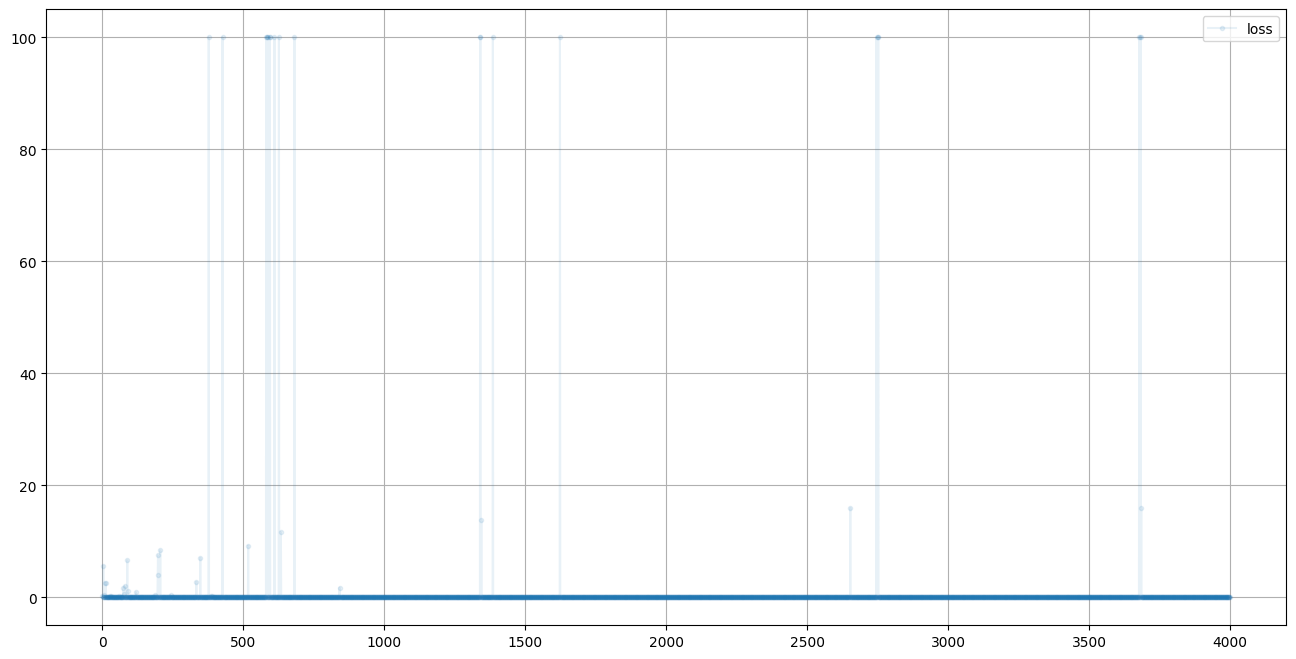

In [ ]:
D.plot_progress()

In [ ]:
import random
for i in range(4):
    img = dataset[random.randint(0, 20000)]
    print(D.forward(img.to(device)).item())

for i in range(4):
    print(D.forward(generate_random_image((1, 3, 128, 128))).item())

1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0


In [ ]:
G = Generator()
fake_img_t = G.forward(generate_random_seed(100))
fake_img_t.shape

torch.Size([1, 3, 128, 128])

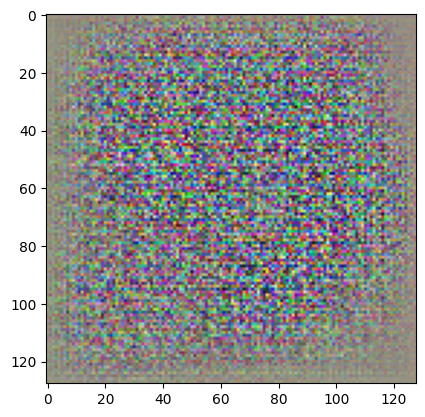

In [ ]:
fake_img = fake_img_t.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
plt.imshow(fake_img)

In [ ]:
D = Discriminator()
G = Generator()
D.to(device)
G.to(device)
pbar = tqdm(total=len(dataset))

with pbar:
    for img in dataset:
        img = img.to(device=device)
        D.train(img, label_1)
        fake_img = G.forward(generate_random_seed(100)).detach()
        D.train(fake_img, label_0)
        G.train(D, generate_random_seed(100))
        pbar.update(1)

  0%|          | 0/20000 [00:00<?, ?it/s]